In [1]:
import numpy as np
import matplotlib.pyplot as plt

import layers
from layers import affine_relu_forward, affine_backward
from data_utils import get_CIFAR10_data
from fc_net import FullyConnectedNet
from solver import Solver
%matplotlib inline

In [2]:
np.set_printoptions(formatter={'all': lambda x:"%.2f" %x})

In [3]:
cifar10_dir = "/Users/mahrokh/Desktop/cifar-10-batches-py"
data = get_CIFAR10_data(cifar10_dir)
for k, v in data.items():
    print('%-7s:' %k, v.shape)

X_train: (49000, 3, 32, 32)
y_train: (49000,)
X_val  : (1000, 3, 32, 32)
y_val  : (1000,)
X_test : (1000, 3, 32, 32)
y_test : (1000,)


In [4]:
x_train, y_train = data['X_train'], data['y_train']
x_val,   y_val   = data['X_val']  , data['y_val']
x_test,  y_test  = data['X_test'] , data['y_test']

# implementing two layer NN

In [5]:
from layers import *

def two_layer_network_loss(x, y, params):
    w1, b1 = params['w1'], params['b1']
    w2, b2 = params['w2'], params['b2']
    
    ################
    # forward step #
    ################
    h, cache_h = affine_relu_forward(x, w1, b1)
    scores, cache_o = affine_forward(h, w2, b2)
    
    #######################
    # compute data a loss #
    #######################
    loss, dscore = softmax_loss(scores, y)
    
    ################
    # backward step #
    ################
    dh, dw2, db2 = affine_backward(dscore, cache_o)
    _, dw1, db1 = affine_relu_backward(dh, cache_h)
    
    grads = {'w1': dw1, 'b1': db1, 'w2': dw2, 'b2': db2}
    return loss, grads

In [6]:
def predict(x, params):
    w1, b1 = params['w1'], params['b1']
    w2, b2 = params['w2'], params['b2']
    
    ################
    # forward step #
    ################
    h, _ = affine_relu_forward(x, w1, b1)
    scores, _ = affine_forward(h, w2, b2)
    
    return np.argmax(scores, axis=1)

In [7]:
def accuracy(y_pred, y_true):
    return 100.0* np.mean(y_pred == y_true)

# Multi Layers NN

In [38]:
def multi_layer_network_loss(X, y, params):
    num_layers = len(params) // 2
    
    ################
    # forward step #
    ################
    loss = 0.0
    cache, h = {}, X
    
    for i in range(1, num_layers + 1):
        W, b = params['W%d' % i], params['b%d' % i]
        
        if i < num_layers:  # hidden layer
            h, cache[i] = affine_relu_forward(h, W, b)
        else:
            scores, cache[i] = affine_forward(h, W, b)
        
        loss += 0.5 * reg * np.sum(W * W)  # regularization loss
        
    #####################
    # Compute data loss #
    #####################
    data_loss, dscores = softmax_loss(scores, y)
    loss += data_loss
           
    #################
    # Backward step #
    #################
    grads = {}
    for i in reversed(range(1, num_layers + 1)):
        
        if i == num_layers:  # output layer
            dout, dW, db = affine_backward(dscores, cache[i])
        else:  # hidden layer
            dout, dW, db = affine_relu_backward(dout, cache[i])
        
        W = params['W%d' % i]
        grads['W%d' % i] = dW + reg * W
        grads['b%d' % i] = db
                       
    return loss, grads

### predict

In [39]:
def predict(x, params):
    h = x
    for i in range (1, num_layers+1):
        w, b = params['w%d'%i], params['b%d'%i]
        
        if i < num_layers: #hidden layers
            h, _ = affine_relu_forward(h, w, b)
        else:
            scores, _ = affine_forward(h, w, b)
        
    return np.argmax(scores, axis=1)

# Minimize Loss Function

In [40]:
num_input = 3072
num_output = 10
hidden_dims = [200, 200, 200, 200]

#### gradient descent

In [41]:
def affine_relu_forward(x, w, b):
    out, cache_a = affine_forward(x, w, b)
    out, cache_r = relu_forward(out)
    return out, (cache_a, cache_r)

def affine_relu_backward(dout, cache):
    cache_a, cache_r = cache
    dout = relu_backward(dout, cache_r)
    dx, dw, db = affine_backward(dout, cache_a)
    return dx, dw, db

In [42]:
x_train = np.reshape(x_train, (x_train.shape[0], -1))
y_train = np.reshape(y_train, (y_train.shape[0], -1))
x_val = np.reshape(x_val, (x_val.shape[0], -1))
y_val = np.reshape(y_val, (y_val.shape[0], -1))
x_test = np.reshape(x_test, (x_val.shape[0], -1))

print(y_train.shape)


(49000, 1)


In [43]:
def params():
    w = 0.001 * np.random.randn(3072, 10)
    b = np.zeros((10,0))
    return w,b

In [44]:
# initialize parameters
params = {}
dims = [num_input] + hidden_dims + [num_output]
num_layers = len(dims) - 1

for i in range(1, num_layers+1):
    params['w%d'%i] = 0.3 * np.random.randn(dims[i-1], dims[i])
    params['b%d'%i] = np.zeros(dims[i])
    
N = x_train.shape[0] 

# hyper parameters
n_iterations = 2000
batch_size = 256

lr = 0.05
reg = 1e-5

loss_history = []
best_params = params.copy()
best_val = 0

# gradient descent
for i in range(n_iterations+1):
    
    # create a batch of training data
    idx = np.random.choice(N, batch_size)
    x_batch, y_batch = x_train[idx], y_train[idx]
    
    loss, grads = multi_layers_network_loss(x_batch, y_batch, params)
    loss_history.append(loss)
    
    # report every 100 iterations
    if i %100 == 0:
        
        y_train_pred = predict(x_batch, params)
        train_acc = accuracy(y_train_pred, y_batch)
        
        y_val_pred = predict(x_val, params)
        val_acc = accuracy(y_val_pred, y_val)
        
        if val_acc > best_val:
            best_val = val_acc
            best_params = params.copy()
            
        print('%4d: loss = %.2f |train accuracy = %5.2f |validation accuracy = %5.2f'
              %(i, loss, train_acc, val_acc))
        
    # update parameters
    for p in params:
        params[p] -= lr * grads[p]

   0: loss = 27129811.97 |train accuracy = 10.39 |validation accuracy = 10.43


/Users/mahrokh/machineLearning with Python- razavi/practice-me/layers.py:273: RuntimeWarning: invalid value encountered in subtract
  shifted_logits = scores - np.max(scores, axis=1, keepdims=True)


 100: loss = nan |train accuracy = 12.50 |validation accuracy =  8.70
 200: loss = nan |train accuracy =  8.59 |validation accuracy =  8.70
 300: loss = nan |train accuracy =  8.59 |validation accuracy =  8.70
 400: loss = nan |train accuracy =  8.98 |validation accuracy =  8.70
 500: loss = nan |train accuracy = 10.94 |validation accuracy =  8.70
 600: loss = nan |train accuracy = 12.50 |validation accuracy =  8.70
 700: loss = nan |train accuracy =  9.77 |validation accuracy =  8.70
 800: loss = nan |train accuracy =  8.59 |validation accuracy =  8.70
 900: loss = nan |train accuracy = 10.16 |validation accuracy =  8.70
1000: loss = nan |train accuracy =  9.38 |validation accuracy =  8.70
1100: loss = nan |train accuracy = 10.94 |validation accuracy =  8.70
1200: loss = nan |train accuracy = 12.89 |validation accuracy =  8.70
1300: loss = nan |train accuracy =  8.20 |validation accuracy =  8.70
1400: loss = nan |train accuracy =  8.98 |validation accuracy =  8.70
1500: loss = nan |tr

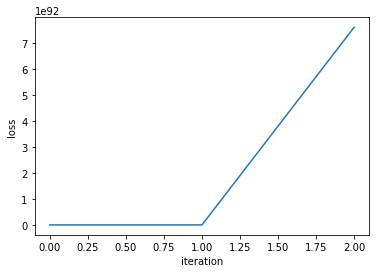

In [45]:
plt.plot(loss_history)
plt.xlabel('iteration')
plt.ylabel('loss');

### Prediction on test data

In [46]:
test_pred = predict(x_test, best_params)
test_accuracy = accuracy(test_pred, y_test)
print('test accuracy = %.2f' %test_accuracy)

test accuracy = 10.30


# Dropout

In [47]:
def dropout_forward(x, p):
    mask = (np.random.rand(*x.shape) < (1-p))/(1-p)
    out = x * mask
    cache = (mask, p)
    out = out.astype(x.dtype, copy= False)
    return out, cache

def dropout_backward(dout, cache):
    mask, p = cache
    dx = dout * mask
    return dx

In [51]:
x = np.random.rand(10)
print(x)

x_dropout, _ = dropout_forward(x, 0.4)
print(x_dropout)

[0.58 0.44 0.33 0.12 0.57 0.22 0.32 0.90 0.48 0.86]
[0.00 0.74 0.55 0.20 0.96 0.00 0.00 1.50 0.80 1.44]
